# Training one signal

This notebook contains the base training and validating for a single signal

In the initial case we look at training on Acceleration

In [1]:
%cd ..

c:\Users\joonn\Desktop\pyscript
 Volume in drive C has no label.
 Volume Serial Number is CCA6-9910

 Directory of c:\Users\joonn\Desktop\pyscript

09/21/2022  09:54 AM    <DIR>          .
09/21/2022  09:54 AM    <DIR>          ..
08/19/2022  12:02 PM    <DIR>          .vscode
09/21/2022  09:54 AM    <DIR>          COP analysis
09/21/2022  09:55 AM    <DIR>          displacement_metrics
09/21/2022  09:54 AM    <DIR>          stf_main
09/21/2022  09:41 AM    <DIR>          utils
               0 File(s)              0 bytes
               7 Dir(s)  302,542,823,424 bytes free


In [2]:
from tensorflow import keras
from models.ts_cnn import TS_CNN as ts_cnn
import numpy as np
from sklearn.model_selection import train_test_split
from models.loader import loader
import matplotlib.pyplot as plt
from sklearn import preprocessing
from utils.normalisation import min_max

c:\Users\joonn\Desktop\pyscript\fs_processor_main


# Load Data

In [79]:
# Data
x_positive = np.loadtxt('data/processed/incidents_acc_combined.txt')
x_negative = np.loadtxt('data/processed/no_incidents_acc_may.txt')
# x_negative = preprocessing.normalize(x_negative)

x_noise = np.random.rand(300, 200)
x_negative = np.concatenate([x_noise, x_negative])

# Labels
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])

print(f'x positive: {x_positive.shape}')
print(f'x negative: {x_negative.shape}')
print(f'y positive: {x_positive.shape}')
print(f'y negative: {x_negative.shape}')

x positive: (638, 200)
x negative: (1156, 200)
y positive: (638, 200)
y negative: (1156, 200)


In [80]:
scaler = preprocessing.StandardScaler()
x = np.concatenate([x_positive, x_negative], axis=0)

x_normalised = []
for i in range(x.shape[0]): 
    try:
        x_normalised.append(min_max(x[i].tolist()))
    except:
        continue

x = np.asarray(x_normalised)

y = np.concatenate([y_positive, y_negative], axis=0)
x_scaled = preprocessing.normalize(x)

print(f'x: {x_scaled.shape}')
print(f'y: {y.shape}')



x: (1794, 200)
y: (1794,)


In [ ]:
# Create a categorical variable for the labels
# if any NAN values are present, remove them

y = y.reshape(len(y), 1)
y = keras.utils.to_categorical(y)

print(f'x: {x.shape}')
print(f'nans: {np.any(np.isnan(x))}')
print(f'y: {y.shape}')

if np.any(np.isnan(x)):
    print('NANs found')
    idx = ~np.isnan(x).any(axis=1) # find the nans if any
    x = x[idx]
    y = y[idx]
    print(f'x: {x.shape}')
    print(f'y: {y.shape}')


### Loader if necessary 

In [6]:
# train_ds = loader(X_train, y_train, batch_size=50, train=True)
# valid_ds = loader(X_test, y_test, batch_size=50, train=False)

# Train Network

In [82]:
model = ts_cnn()

idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.00001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

optimizer = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer,
                loss=['binary_crossentropy'],
                metrics=['accuracy'])


In [83]:
epochs = 200
batch_size = 64
model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    # callbacks=callbacks,
    validation_split=0.4,
    verbose=2,
)
history = model.history.history

Epoch 1/200
17/17 - 2s - loss: 0.5833 - accuracy: 0.7500 - val_loss: 0.6883 - val_accuracy: 0.8022 - 2s/epoch - 134ms/step
Epoch 2/200
17/17 - 0s - loss: 0.4715 - accuracy: 0.8113 - val_loss: 0.6787 - val_accuracy: 0.8148 - 257ms/epoch - 15ms/step
Epoch 3/200
17/17 - 0s - loss: 0.4228 - accuracy: 0.8318 - val_loss: 0.6680 - val_accuracy: 0.8092 - 277ms/epoch - 16ms/step
Epoch 4/200
17/17 - 0s - loss: 0.4027 - accuracy: 0.8290 - val_loss: 0.6582 - val_accuracy: 0.8162 - 272ms/epoch - 16ms/step
Epoch 5/200
17/17 - 0s - loss: 0.3859 - accuracy: 0.8327 - val_loss: 0.6477 - val_accuracy: 0.8217 - 261ms/epoch - 15ms/step
Epoch 6/200
17/17 - 0s - loss: 0.3797 - accuracy: 0.8457 - val_loss: 0.6396 - val_accuracy: 0.8259 - 278ms/epoch - 16ms/step
Epoch 7/200
17/17 - 0s - loss: 0.3671 - accuracy: 0.8559 - val_loss: 0.6277 - val_accuracy: 0.8287 - 271ms/epoch - 16ms/step
Epoch 8/200
17/17 - 0s - loss: 0.3622 - accuracy: 0.8597 - val_loss: 0.6155 - val_accuracy: 0.8301 - 271ms/epoch - 16ms/step
Ep

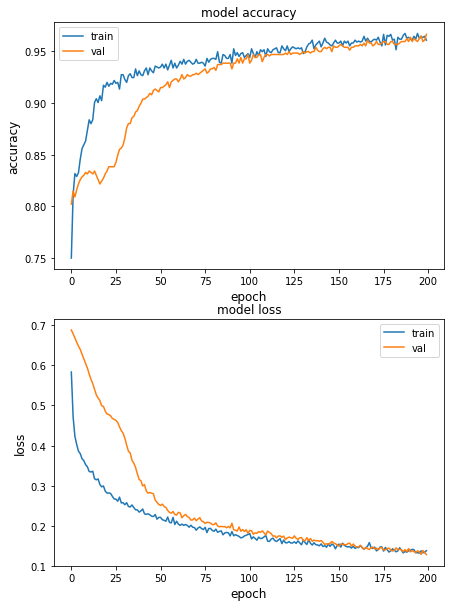

In [84]:
plt.figure(figsize=(7, 10))
metric = "accuracy"
plt.subplot(2, 1, 1)
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")

plt.subplot(2, 1, 2)
metric = "loss"
plt.plot(history[metric])
plt.plot(history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

# Save TFLITE Model

In [85]:
# save model weights
model.save_weights("06_19_weights_noise.h5")

In [87]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('06_19_model_noise.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\joonn\AppData\Local\Temp\tmpauxlk5v8\assets


INFO:tensorflow:Assets written to: C:\Users\joonn\AppData\Local\Temp\tmpauxlk5v8\assets


# Inference

In [33]:
model = ts_cnn()
model.load_weights('06_18_weights.h5')

In [88]:
idx = np.random.permutation(len(x))
x = x[idx]
y = y[idx]

In [89]:
print(y[:5]) # see a couple of examples
np.argmax(y, axis=1)[:5]    

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [91]:
# find how many positive and negative samples are in the dataset
print(f'positive: {np.sum(np.argmax(y, axis=1) == 0)}')
print(f'negative: {np.sum(np.argmax(y, axis=1) == 1)}')

positive: 1156
negative: 638


In [ ]:
# y_val = np.reshape(y, (len(y),))
y_val = y.argmax(axis=1)
y_pred = np.argmax(model.predict(x),axis=1)

# find how many positive and negative samples are in the predicted dataset
print(f'positive: {np.sum(y_pred == 0)}')
print(f'negative: {np.sum(y_pred == 1)}')

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_pred, labels=[0,1])

In [ ]:
# Matrix without labels
ax = sns.heatmap(result/np.sum(result), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Incidents')
ax.set_ylabel('Actual Incidents ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()


In [ ]:
# Matrix with labels
group_names = ['No Incident','False Pred Incident','False Pred No Inceint','Incident']
group_counts = ["{0:0.0f}".format(value) for value in result.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in result.flatten()/np.sum(result)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(result, annot=labels, fmt='', cmap='Blues')
ax.set_title('06.18 Model Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Validation

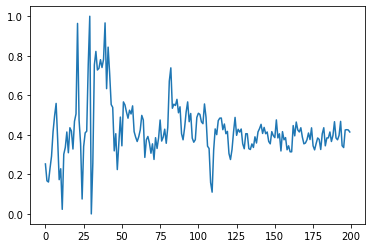

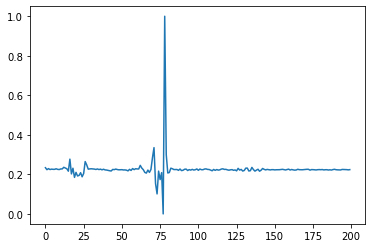

Predictions [0] : [1]


In [ ]:
f = [0, 1]

plt.figure()
plt.plot(x[f[0]])
plt.show()
plt.figure()
plt.plot(x[f[1]])
plt.show()
print(f'Predictions [{y_pred[f[0]]}] : [{y_pred[f[1]]}]')

In [ ]:
import random

# create an array with random numbers from 0 to 1
x_test = np.random.rand(100, 200)
# x_test = x_test.reshape(1, len(x_test), 1)
# use model to predict the class of the random numbers
pred = model.predict(x_test)
print(pred)

### Validating Individual Instances

In [113]:
z = np.random.rand(200)

In [123]:
pred = model.predict(z.reshape(1, len(z), 1))
print(np.argmax(pred,axis=1))

1/1 [==============================] - 0s 23ms/step
[0]


In [124]:
if pred[0][0] > pred[0][1]:
    print('Prediction: No incident')
else:
    print('Prediction: Incident')

Prediction: No incident
